# So sánh 4 Models: 2 phân loại (LightGBM, XGBoost) & 2 hồi quy (LightGBM, XGBoost)

Notebook này so sánh hiệu suất của 2 mô hình phân loại (dự đoán tăng/giảm) và 2 mô hình hồi quy (dự đoán mức lợi nhuận).

**Models:**
- Phân loại: LightGBM, XGBoost
- Hồi quy: LightGBM Regressor, XGBoost Regressor


In [ ]:
        # Import libraries
        import os
        import warnings
        warnings.filterwarnings("ignore")
        import numpy as np
        import pandas as pd
        import joblib
        import matplotlib.pyplot as plt
        import seaborn as sns
        from pathlib import Path
        from math import pi

        from sklearn.preprocessing import StandardScaler
        from sklearn.metrics import (
            accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
            confusion_matrix, roc_curve, auc, average_precision_score
        )

        import lightgbm as lgb
        import xgboost as xgb

        # Set style
        try:
            plt.style.use('seaborn-v0_8-darkgrid')
        except:
            try:
                plt.style.use('seaborn-darkgrid')
            except:
                plt.style.use('ggplot')
        sns.set_palette("husl")

        # Create ml_model_graph directory if not exists (for saving images)
        os.makedirs("../ml_model_graph", exist_ok=True)

        print("✅ Libraries imported successfully!")


ModuleNotFoundError: No module named 'seaborn'

## 1. Load Data


In [ ]:
# Load data
DATA_FILE = "../data/features_engineered.csv"
df = pd.read_csv(DATA_FILE, parse_dates=["date"])
df = df.sort_values(["date", "symbol"]).reset_index(drop=True)
df = df.dropna(subset=["label_up_down", "target_return"])

print(f"Data shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nFirst few rows:")
df.head()


Data shape: (4649, 39)
Date range: 2021-03-19 00:00:00 to 2021-10-28 00:00:00

First few rows:


,date,open,high,low,close,volume,symbol,SMA_5,SMA_10,SMA_20,...,log_return,volatility_10,volatility_30,volume_ma_10,volume_ratio,momentum_5,momentum_10,MA_cross,label_up_down,target_return
0,2021-03-19,45.00,45.4,44.7,45.00,2885400,BID,43.74,43.165,43.305,...,0.000000,0.018411,0.020150,2822160.0,1.022408,1.65,2.60,0.0,0.0,-0.777778
1,2021-03-19,60.70,63.7,60.7,61.00,3085100,BVH,60.20,59.960,60.175,...,0.004930,0.009114,0.024969,831260.0,3.711354,0.50,2.00,0.0,1.0,1.967213
2,2021-03-19,40.35,40.9,40.3,40.45,8587200,CTG,39.24,38.500,38.105,...,-0.001235,0.019481,0.023108,10277690.0,0.835518,2.50,2.45,1.0,1.0,1.606922
3,2021-03-19,80.00,80.5,79.4,79.80,2923500,FPT,79.82,77.940,77.240,...,-0.014926,0.020732,0.022908,3167742.3,0.922897,3.30,3.90,1.0,0.0,-1.378446
4,2021-03-19,90.50,90.9,89.7,90.90,1016800,GAS,91.38,92.140,91.145,...,-0.009852,0.017103,0.022004,745980.0,1.363039,-0.20,-1.60,1.0,0.0,-0.440044


In [ ]:
# Prepare features
exclude_cols = {"date", "symbol", "label_up_down", "target_return"}
feature_cols = [c for c in df.columns if c not in exclude_cols]
X_all = df[feature_cols].copy()
y_all = df["label_up_down"].astype(int).copy()

print(f"Number of features: {len(feature_cols)}")
print(f"Target distribution:\n{y_all.value_counts()}")
print(f"\nTarget distribution (%):\n{y_all.value_counts(normalize=True) * 100}")


Number of features: 35
Target distribution:
label_up_down
0    2384
1    2265
Name: count, dtype: int64

Target distribution (%):
label_up_down
0    51.279845
1    48.720155
Name: proportion, dtype: float64


## 2. Load Models


In [ ]:
# Load models
MODEL_PATH_LGB = "../models/lgb_model.txt"
MODEL_PATH_XGB = "../models/xgb_model.json"
MODEL_PATH_LGB_REG = "../models/lgb_reg.txt"
MODEL_PATH_XGB_REG = "../models/xgb_reg.json"
SCALER_PATH = "../models/scaler.pkl"

# Load scaler
scaler = joblib.load(SCALER_PATH)
X_all_scaled = scaler.transform(X_all)

# Load classification models
lgb_model = lgb.Booster(model_file=MODEL_PATH_LGB)
xgb_model = xgb.Booster()
xgb_model.load_model(MODEL_PATH_XGB)

# Load regression models
lgb_reg_model = lgb.Booster(model_file=MODEL_PATH_LGB_REG)
xgb_reg_model = xgb.Booster()
xgb_reg_model.load_model(MODEL_PATH_XGB_REG)

print("✅ All models loaded successfully!")
print(f"Features shape: {X_all_scaled.shape}")


✅ All models loaded successfully!
Features shape: (4649, 35)


## 3. Make Predictions


In [ ]:
# Safe XGBoost prediction function
def safe_xgb_predict(booster, dmatrix):
    """Safe XGBoost prediction"""
    ntree_limit = None
    if hasattr(booster, "best_ntree_limit") and getattr(booster, "best_ntree_limit") is not None:
        ntree_limit = booster.best_ntree_limit
    elif hasattr(booster, "best_iteration") and getattr(booster, "best_iteration") is not None:
        ntree_limit = getattr(booster, "best_iteration")
    try:
        if ntree_limit is not None:
            return booster.predict(dmatrix, ntree_limit=ntree_limit)
        else:
            return booster.predict(dmatrix)
    except TypeError:
        return booster.predict(dmatrix)

# Make predictions - Classification
if hasattr(lgb_model, "best_iteration") and lgb_model.best_iteration is not None:
    y_pred_lgb = lgb_model.predict(X_all_scaled, num_iteration=lgb_model.best_iteration)
else:
    y_pred_lgb = lgb_model.predict(X_all_scaled)

xgb_dmatrix = xgb.DMatrix(X_all_scaled)
y_pred_xgb = safe_xgb_predict(xgb_model, xgb_dmatrix)

# Make predictions - Regression
if hasattr(lgb_reg_model, "best_iteration") and lgb_reg_model.best_iteration is not None:
    y_pred_lgb_reg = lgb_reg_model.predict(X_all_scaled, num_iteration=lgb_reg_model.best_iteration)
else:
    y_pred_lgb_reg = lgb_reg_model.predict(X_all_scaled)

y_pred_xgb_reg = safe_xgb_predict(xgb_reg_model, xgb_dmatrix)

print("✅ Predictions completed for 4 models (2 cls + 2 reg)!")
print(f"\nPrediction statistics (classification):")
print(f"LightGBM:   min={y_pred_lgb.min():.4f}, max={y_pred_lgb.max():.4f}, mean={y_pred_lgb.mean():.4f}")
print(f"XGBoost:    min={y_pred_xgb.min():.4f}, max={y_pred_xgb.max():.4f}, mean={y_pred_xgb.mean():.4f}")
print(f"\nPrediction statistics (regression):")
print(f"LGBM-Reg:   min={y_pred_lgb_reg.min():.4f}, max={y_pred_lgb_reg.max():.4f}, mean={y_pred_lgb_reg.mean():.4f}")
print(f"XGB-Reg:    min={y_pred_xgb_reg.min():.4f}, max={y_pred_xgb_reg.max():.4f}, mean={y_pred_xgb_reg.mean():.4f}")


✅ Predictions completed for 4 models (2 cls + 2 reg)!



Prediction statistics (classification):
LightGBM:   min=0.2898, max=0.7664, mean=0.4965
XGBoost:    min=0.1360, max=0.9032, mean=0.4879

Prediction statistics (regression):
LGBM-Reg:   min=-0.1555, max=0.2487, mean=0.0866
XGB-Reg:    min=-29.6776, max=5.4328, mean=0.0895


## 4. Load Results từ CSV files


In [ ]:
# Load summary results
results_summary = pd.read_csv("../results/ml_results_summary.csv")
fold_metrics = pd.read_csv("../results/fold_metrics.csv")
daily_backtest = pd.read_csv("../results/daily_backtest.csv", parse_dates=["date"])

print("✅ Results loaded!")
print(f"\nResults summary shape: {results_summary.shape}")
print(f"Fold metrics shape: {fold_metrics.shape}")
print(f"Daily backtest shape: {daily_backtest.shape}")
print(f"\nFold metrics:\n{fold_metrics.head()}")


✅ Results loaded!

Results summary shape: (1, 14)
Fold metrics shape: (6, 13)
Daily backtest shape: (155, 5)

Fold metrics:
   fold   lgb_acc    lgb_f1   lgb_auc   xgb_acc    xgb_f1   xgb_auc  \
0     1  0.400000  0.500000  0.531250  0.366667  0.486486  0.325893   
1     2  0.600000  0.647059  0.644444  0.500000  0.545455  0.537778   
2     3  0.466667  0.272727  0.701923  0.333333  0.166667  0.528846   
3     4  0.466667  0.272727  0.525463  0.433333  0.260870  0.458333   
4     5  0.833333  0.761905  0.855204  0.800000  0.750000  0.846154   

   lgb_reg_mae  lgb_reg_rmse  lgb_reg_r2  xgb_reg_mae  xgb_reg_rmse  \
0     1.086170      1.672402   -0.005401     1.785589      2.147372   
1     1.648110      2.043016   -0.027611     1.749836      2.152608   
2     4.705294      6.845127   -0.729802     4.946368      7.048499   
3     1.658607      2.212991   -0.198678     1.733165      2.296905   
4     1.065609      1.359540    0.207069     1.047931      1.464345   

   xgb_reg_r2  
0   -0

## 5. Tính toán Metrics cho tất cả Models


In [ ]:
# Calculate metrics function
def calculate_metrics(y_true, y_proba, model_name):
    # Find best threshold
    thrs = np.linspace(0.1, 0.9, 81)
    best_thr, best_f1 = 0.5, 0
    for t in thrs:
        y_pred = (y_proba >= t).astype(int)
        f1v = f1_score(y_true, y_pred, zero_division=0)
        if f1v > best_f1:
            best_f1 = f1v
            best_thr = t
    
    y_pred_best = (y_proba >= best_thr).astype(int)
    
    return {
        "model": model_name,
        "auc": roc_auc_score(y_true, y_proba),
        "ap": average_precision_score(y_true, y_proba),
        "accuracy": accuracy_score(y_true, y_pred_best),
        "precision": precision_score(y_true, y_pred_best, zero_division=0),
        "recall": recall_score(y_true, y_pred_best, zero_division=0),
        "f1": best_f1,
        "best_threshold": best_thr
    }

# Calculate metrics for classification
metrics_lgb = calculate_metrics(y_all, y_pred_lgb, "LightGBM")
metrics_xgb = calculate_metrics(y_all, y_pred_xgb, "XGBoost")

all_metrics = pd.DataFrame([metrics_lgb, metrics_xgb])
print("Classification Metrics Summary:")
print(all_metrics.round(4))

# Regression metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def reg_metrics(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    return {
        "model": name,
        "mae": mean_absolute_error(y_true, y_pred),
        "rmse": np.sqrt(mse),
        "r2": r2_score(y_true, y_pred)
    }

# target for regression
y_reg = df["target_return"].values

metrics_lgb_reg = reg_metrics(y_reg, y_pred_lgb_reg, "LGBM-Reg")
metrics_xgb_reg = reg_metrics(y_reg, y_pred_xgb_reg, "XGB-Reg")
reg_metrics_df = pd.DataFrame([metrics_lgb_reg, metrics_xgb_reg])

print("\nRegression Metrics Summary:")
print(reg_metrics_df.round(4))


Classification Metrics Summary:
      model     auc      ap  accuracy  precision  recall      f1  \
0  LightGBM  0.8480  0.8403    0.7591     0.7223  0.8212  0.7686   
1   XGBoost  0.9477  0.9445    0.8722     0.8509  0.8945  0.8721   

   best_threshold  
0            0.48  
1            0.48  

Regression Metrics Summary:
      model     mae    rmse      r2
0  LGBM-Reg  1.5743  2.4336  0.0085
1   XGB-Reg  1.2738  1.7573  0.4830


## 6. Biểu đồ 1: So sánh Metrics (Bar Chart)


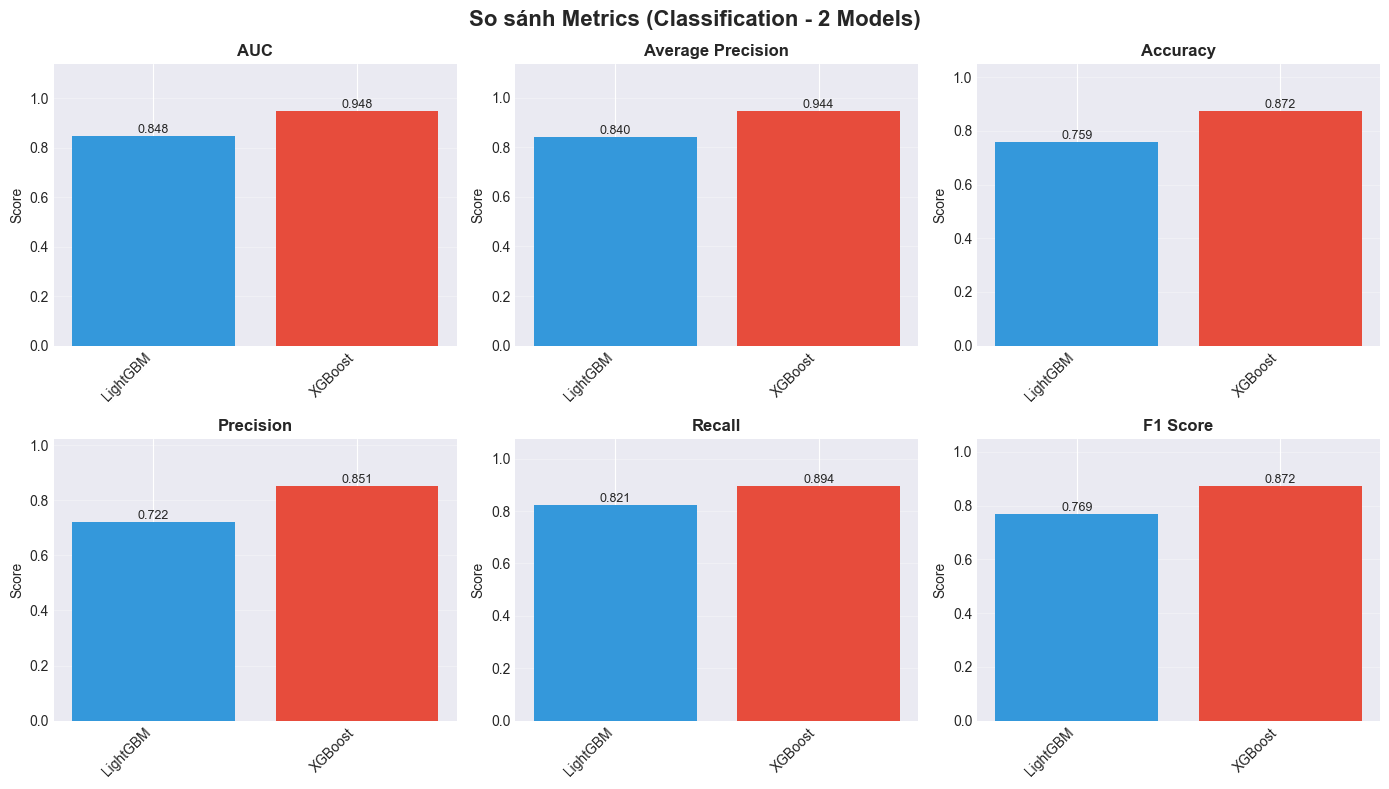

✅ Saved: ../ml_model_graph/model_comparison_metrics.png


In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
fig.suptitle('So sánh Metrics (Classification - 2 Models)', fontsize=16, fontweight='bold')

metrics_to_plot = ['auc', 'ap', 'accuracy', 'precision', 'recall', 'f1']
metric_names = ['AUC', 'Average Precision', 'Accuracy', 'Precision', 'Recall', 'F1 Score']

for idx, (metric, name) in enumerate(zip(metrics_to_plot, metric_names)):
    ax = axes[idx // 3, idx % 3]
    bars = ax.bar(all_metrics['model'], all_metrics[metric], color=['#3498db', '#e74c3c'])
    ax.set_title(f'{name}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=10)
    ax.set_ylim([0, max(all_metrics[metric]) * 1.2])
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)
    
    ax.grid(axis='y', alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('../ml_model_graph/model_comparison_metrics.png', dpi=200, bbox_inches='tight')
plt.show()
print("✅ Saved: ../ml_model_graph/model_comparison_metrics.png")


## 7. Biểu đồ 2: ROC Curves cho tất cả Models


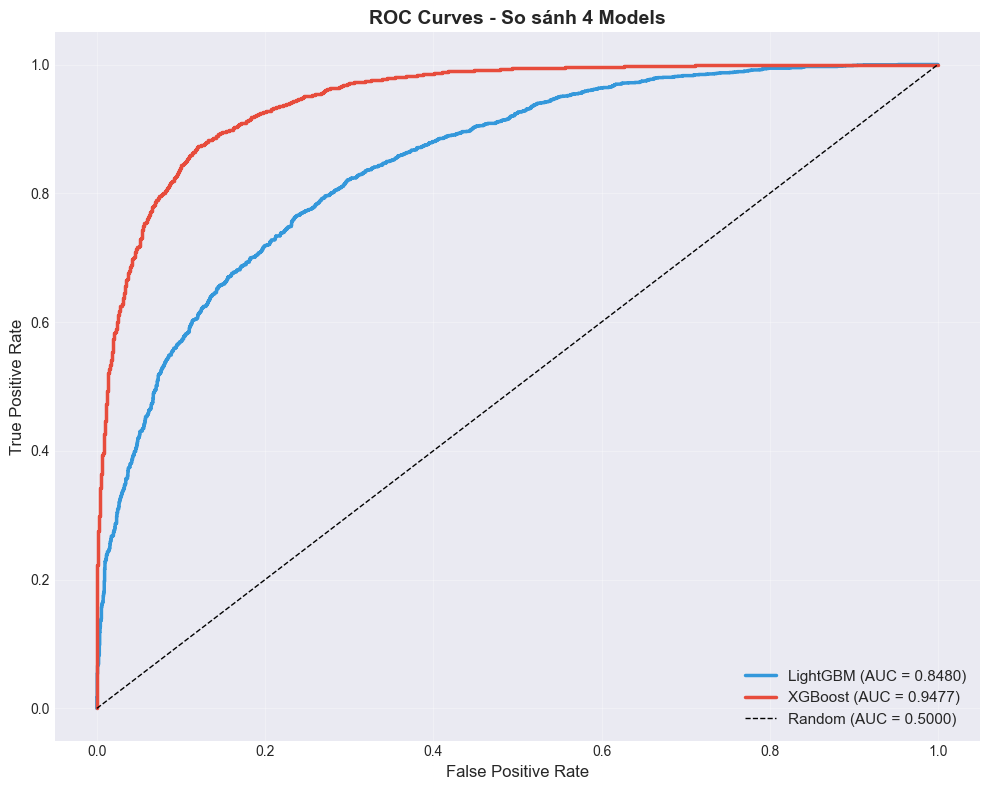

✅ Saved: ../ml_model_graph/roc_curves_all_models.png


In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

models_data = [
    (y_pred_lgb, "LightGBM", "#3498db"),
    (y_pred_xgb, "XGBoost", "#e74c3c")
]

for y_pred, name, color in models_data:
    fpr, tpr, _ = roc_curve(y_all, y_pred)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})', 
            linewidth=2.5, color=color)

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random (AUC = 0.5000)')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - So sánh 4 Models', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../ml_model_graph/roc_curves_all_models.png', dpi=200, bbox_inches='tight')
plt.show()
print("✅ Saved: ../ml_model_graph/roc_curves_all_models.png")


## 8. Biểu đồ 3: Metrics Across Folds


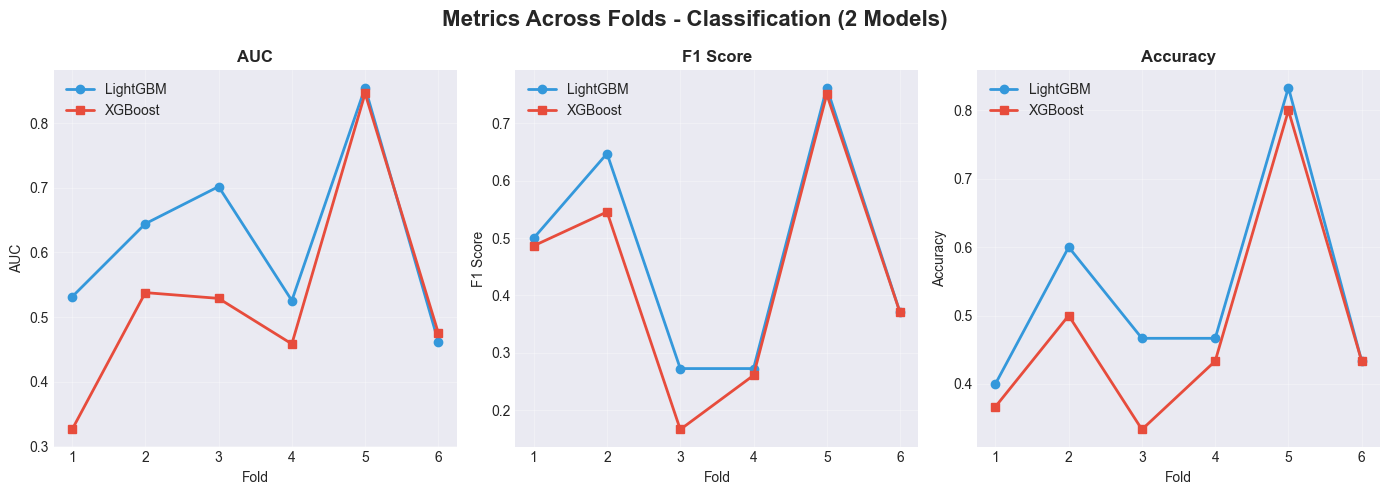

✅ Saved: ../ml_model_graph/metrics_across_folds.png


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
fig.suptitle('Metrics Across Folds - Classification (2 Models)', fontsize=16, fontweight='bold')

metrics_fold = ['auc', 'f1', 'acc']
metric_names_fold = ['AUC', 'F1 Score', 'Accuracy']

for idx, (metric, name) in enumerate(zip(metrics_fold, metric_names_fold)):
    ax = axes[idx]
    
    ax.plot(fold_metrics['fold'], fold_metrics[f'lgb_{metric}'], 
            marker='o', label='LightGBM', linewidth=2, color='#3498db')
    ax.plot(fold_metrics['fold'], fold_metrics[f'xgb_{metric}'], 
            marker='s', label='XGBoost', linewidth=2, color='#e74c3c')
    
    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.set_xlabel('Fold', fontsize=10)
    ax.set_ylabel(name, fontsize=10)
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../ml_model_graph/metrics_across_folds.png', dpi=200, bbox_inches='tight')
plt.show()
print("✅ Saved: ../ml_model_graph/metrics_across_folds.png")


## 9. Biểu đồ 4: Backtest Performance - Cumulative Returns


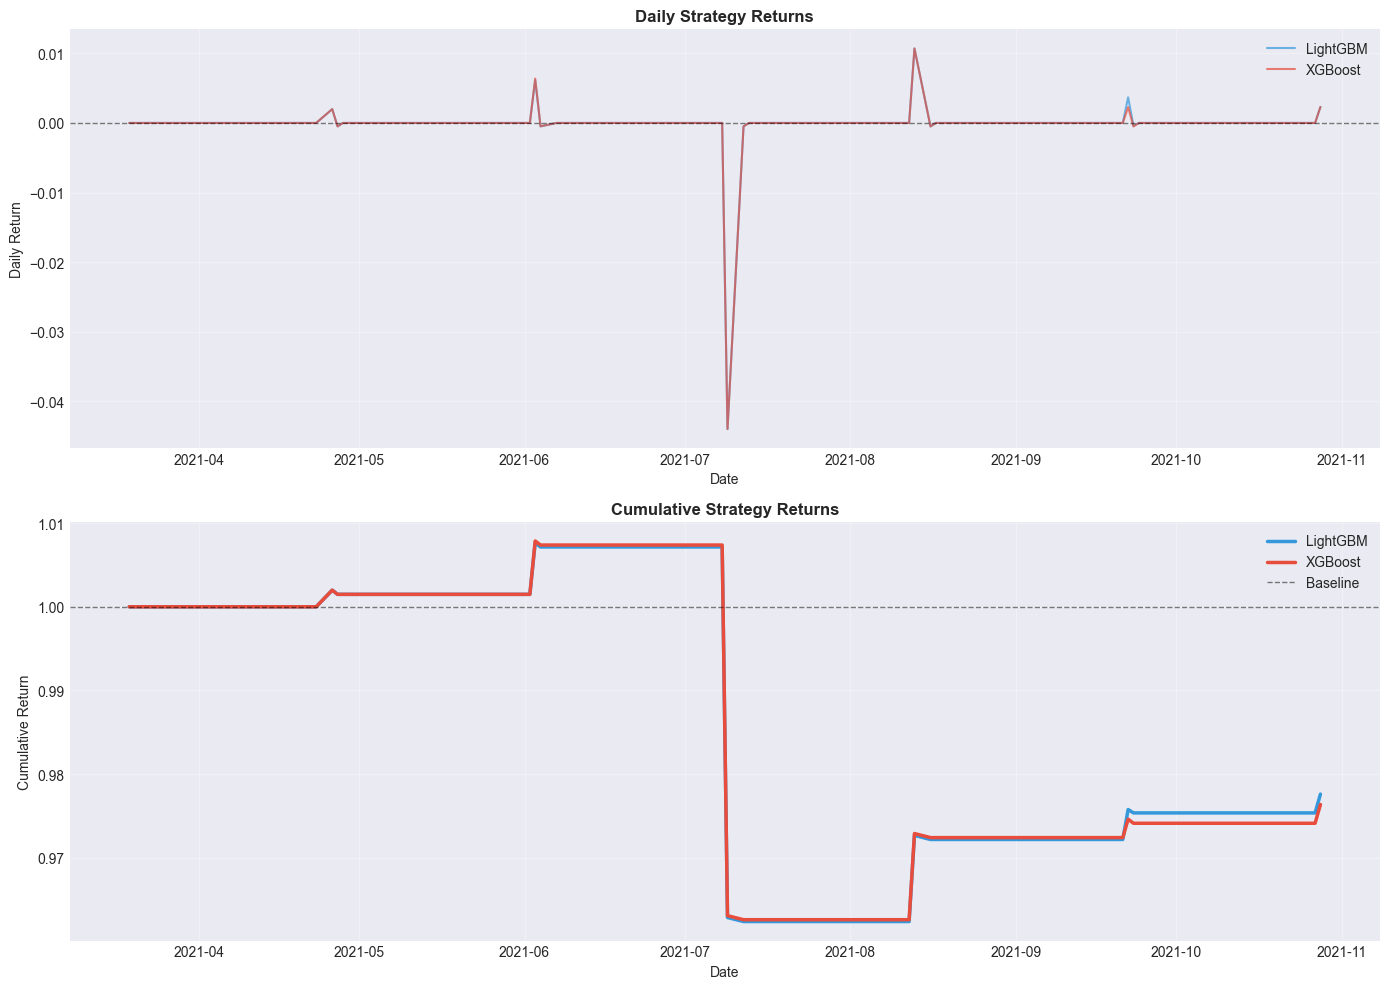

✅ Saved: ../ml_model_graph/backtest_performance.png


In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Daily returns
ax1 = axes[0]
ax1.plot(daily_backtest['date'], daily_backtest['lgb_strat_ret'], 
         label='LightGBM', linewidth=1.5, alpha=0.7, color='#3498db')
ax1.plot(daily_backtest['date'], daily_backtest['xgb_strat_ret'], 
         label='XGBoost', linewidth=1.5, alpha=0.7, color='#e74c3c')
ax1.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_title('Daily Strategy Returns', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date', fontsize=10)
ax1.set_ylabel('Daily Return', fontsize=10)
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# Plot 2: Cumulative returns
ax2 = axes[1]
ax2.plot(daily_backtest['date'], daily_backtest['lgb_strat_ret_cum'], 
         label='LightGBM', linewidth=2.5, color='#3498db')
ax2.plot(daily_backtest['date'], daily_backtest['xgb_strat_ret_cum'], 
         label='XGBoost', linewidth=2.5, color='#e74c3c')
ax2.axhline(y=1.0, color='k', linestyle='--', linewidth=1, alpha=0.5, label='Baseline')
ax2.set_title('Cumulative Strategy Returns', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date', fontsize=10)
ax2.set_ylabel('Cumulative Return', fontsize=10)
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../ml_model_graph/backtest_performance.png', dpi=200, bbox_inches='tight')
plt.show()
print("✅ Saved: ../ml_model_graph/backtest_performance.png")


## 10. Biểu đồ 5: Prediction Distribution


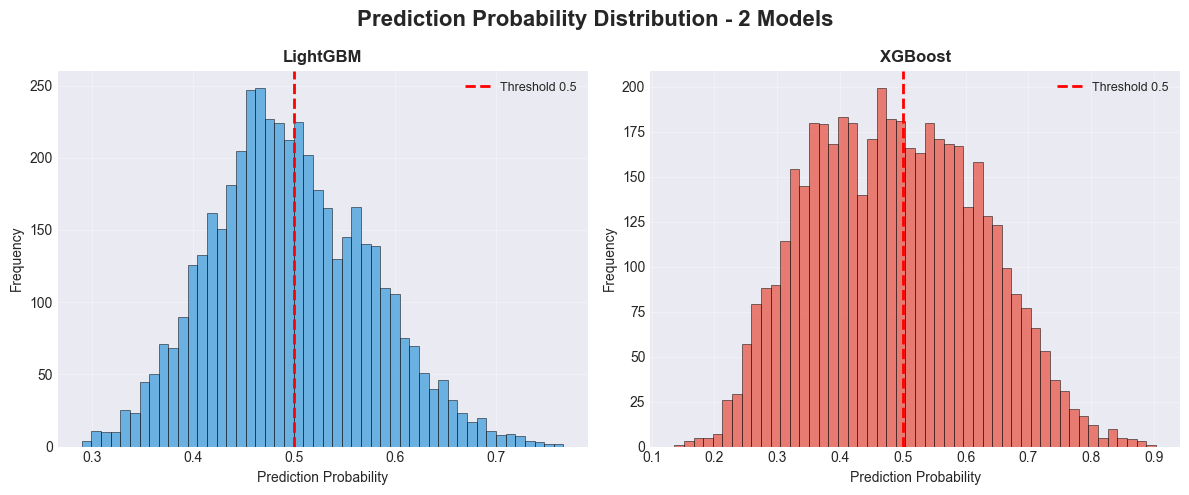

✅ Saved: ../ml_model_graph/prediction_distribution.png


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Prediction Probability Distribution - 2 Models', fontsize=16, fontweight='bold')

models_dist = [
    (y_pred_lgb, "LightGBM", "#3498db"),
    (y_pred_xgb, "XGBoost", "#e74c3c")
]

for idx, (y_pred, name, color) in enumerate(models_dist):
    ax = axes[idx]
    
    # Plot histogram
    ax.hist(y_pred, bins=50, alpha=0.7, color=color, edgecolor='black', linewidth=0.5)
    ax.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold 0.5')
    
    ax.set_title(f'{name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Prediction Probability', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../ml_model_graph/prediction_distribution.png', dpi=200, bbox_inches='tight')
plt.show()
print("✅ Saved: ../ml_model_graph/prediction_distribution.png")


## 11. Biểu đồ 6: Heatmap So sánh Metrics


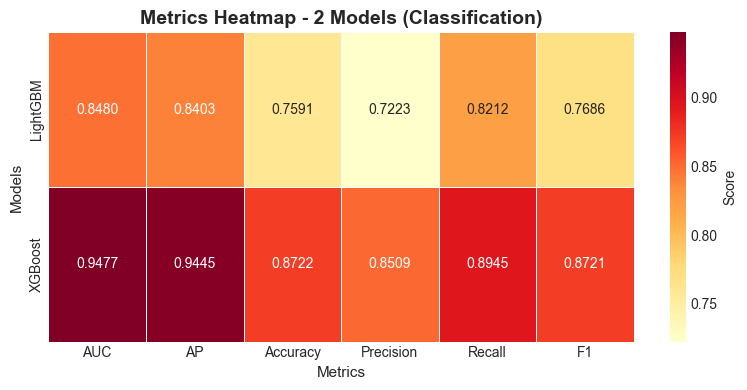

✅ Saved: ../ml_model_graph/metrics_heatmap.png


In [ ]:
# Prepare data for heatmap
heatmap_data = all_metrics.set_index('model')[['auc', 'ap', 'accuracy', 'precision', 'recall', 'f1']]
heatmap_data.columns = ['AUC', 'AP', 'Accuracy', 'Precision', 'Recall', 'F1']

fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='YlOrRd', 
            cbar_kws={'label': 'Score'}, ax=ax, linewidths=0.5)
ax.set_title('Metrics Heatmap - 2 Models (Classification)', fontsize=14, fontweight='bold')
ax.set_xlabel('Metrics', fontsize=11)
ax.set_ylabel('Models', fontsize=11)

plt.tight_layout()
plt.savefig('../ml_model_graph/metrics_heatmap.png', dpi=200, bbox_inches='tight')
plt.show()
print("✅ Saved: ../ml_model_graph/metrics_heatmap.png")


## 12. Biểu đồ 7: Radar Chart so sánh Models


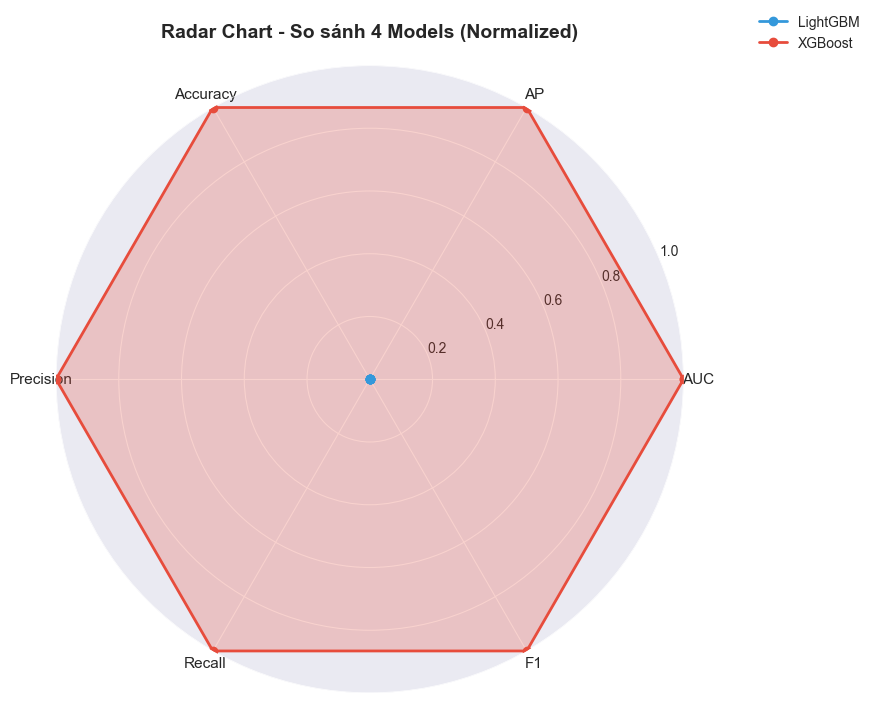

✅ Saved: ../ml_model_graph/radar_chart_models.png


In [ ]:
from math import pi

# Prepare data for radar chart
categories = ['AUC', 'AP', 'Accuracy', 'Precision', 'Recall', 'F1']
N = len(categories)

# Normalize metrics to 0-1 scale for better visualization
metrics_normalized = all_metrics[['auc', 'ap', 'accuracy', 'precision', 'recall', 'f1']].copy()
# Normalize each column to 0-1
for col in metrics_normalized.columns:
    min_val = metrics_normalized[col].min()
    max_val = metrics_normalized[col].max()
    if max_val > min_val:
        metrics_normalized[col] = (metrics_normalized[col] - min_val) / (max_val - min_val)

# Compute angle for each category
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Complete the circle

fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(projection='polar'))

colors = ['#3498db', '#e74c3c']
for idx, row in metrics_normalized.iterrows():
    values = row.values.tolist()
    values += values[:1]  # Complete the circle
    
    ax.plot(angles, values, 'o-', linewidth=2, label=all_metrics.iloc[idx]['model'], color=colors[idx])
    ax.fill(angles, values, alpha=0.25, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11)
ax.set_ylim(0, 1)
ax.set_title('Radar Chart - So sánh 4 Models (Normalized)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
ax.grid(True)

plt.tight_layout()
plt.savefig('../ml_model_graph/radar_chart_models.png', dpi=200, bbox_inches='tight')
plt.show()
print("✅ Saved: ../ml_model_graph/radar_chart_models.png")


## 12bis. Regression Metrics & Plots


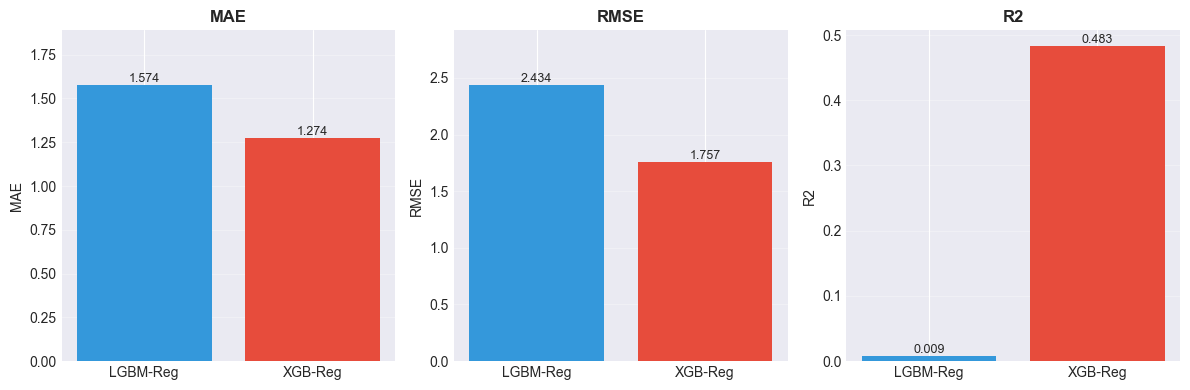

✅ Saved: ../ml_model_graph/reg_metrics_bar.png


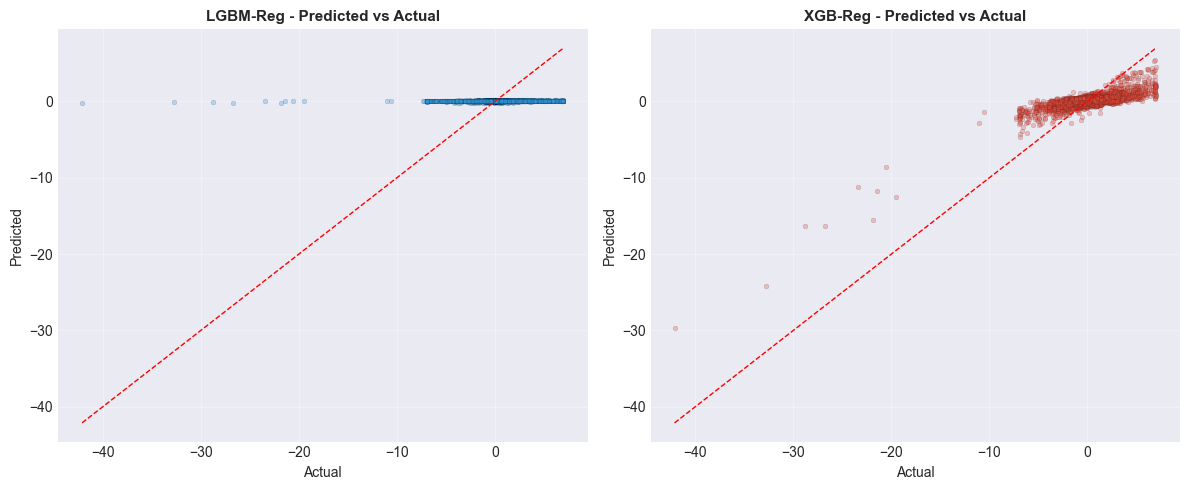

✅ Saved: ../ml_model_graph/reg_pred_vs_actual.png


In [ ]:
# Regression metrics bar
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
metrics_for_bar = ['mae', 'rmse', 'r2']
titles = ['MAE', 'RMSE', 'R2']
colors = ['#3498db', '#e74c3c']

for i, (metric, title) in enumerate(zip(metrics_for_bar, titles)):
    bars = ax[i].bar(reg_metrics_df['model'], reg_metrics_df[metric], color=colors)
    ax[i].set_title(title, fontsize=12, fontweight='bold')
    ax[i].set_ylabel(metric.upper(), fontsize=10)
    if metric != 'r2':
        ax[i].set_ylim(0, reg_metrics_df[metric].max() * 1.2)
    ax[i].grid(axis='y', alpha=0.3)
    for b in bars:
        val = b.get_height()
        ax[i].text(b.get_x() + b.get_width()/2., val, f'{val:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../ml_model_graph/reg_metrics_bar.png', dpi=200, bbox_inches='tight')
plt.show()
print("✅ Saved: ../ml_model_graph/reg_metrics_bar.png")

# Predicted vs Actual (scatter)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
models_reg_pred = [
    (y_reg, y_pred_lgb_reg, 'LGBM-Reg', '#3498db'),
    (y_reg, y_pred_xgb_reg, 'XGB-Reg', '#e74c3c')
]
for i, (y_true, y_pred, name, color) in enumerate(models_reg_pred):
    axes[i].scatter(y_true, y_pred, alpha=0.3, s=12, color=color, edgecolor='k', linewidth=0.2)
    axes[i].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', linewidth=1)
    axes[i].set_title(f'{name} - Predicted vs Actual', fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Actual', fontsize=10)
    axes[i].set_ylabel('Predicted', fontsize=10)
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../ml_model_graph/reg_pred_vs_actual.png', dpi=200, bbox_inches='tight')
plt.show()
print("✅ Saved: ../ml_model_graph/reg_pred_vs_actual.png")


## 13. Tổng kết và Export Results


In [ ]:
# Save comprehensive metrics
all_metrics.to_csv('../ml_model_graph/model_comparison_metrics.csv', index=False)

print("="*60)
print("TỔNG KẾT SO SÁNH 4 MODELS")
print("="*60)
print("\nMetrics Summary:")
print(all_metrics.to_string(index=False))

print("\n" + "="*60)
print("Best Model by Metric:")
print("="*60)
for metric in ['auc', 'ap', 'accuracy', 'precision', 'recall', 'f1']:
    best_idx = all_metrics[metric].idxmax()
    best_model = all_metrics.loc[best_idx, 'model']
    best_value = all_metrics.loc[best_idx, metric]
    print(f"{metric.upper():12s}: {best_model:15s} ({best_value:.4f})")

print("\n✅ All visualizations saved to '../ml_model_graph/' directory!")
print("✅ Metrics saved to '../ml_model_graph/model_comparison_metrics.csv'")


TỔNG KẾT SO SÁNH 4 MODELS

Metrics Summary:
   model      auc       ap  accuracy  precision   recall       f1  best_threshold
LightGBM 0.847999 0.840297  0.759088   0.722330 0.821192 0.768595            0.48
 XGBoost 0.947701 0.944477  0.872231   0.850903 0.894481 0.872148            0.48

Best Model by Metric:
AUC         : XGBoost         (0.9477)
AP          : XGBoost         (0.9445)
ACCURACY    : XGBoost         (0.8722)
PRECISION   : XGBoost         (0.8509)
RECALL      : XGBoost         (0.8945)
F1          : XGBoost         (0.8721)

✅ All visualizations saved to '../ml_model_graph/' directory!
✅ Metrics saved to '../ml_model_graph/model_comparison_metrics.csv'
